### Find Scaling-Relations in real time using an interactive window
* Run the code block below. You will see an interactive window
* Select the prefered options according to the manuscript
* This will generate the Scaling relations for the model chosen.


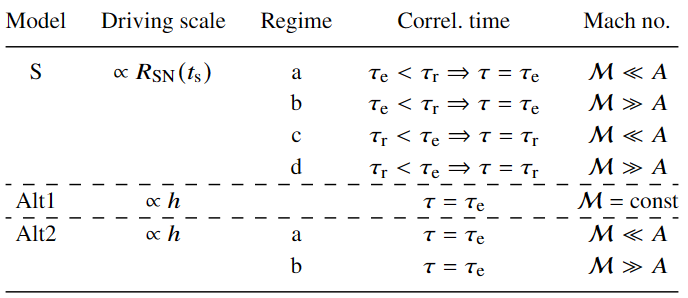

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import *
from fractions import Fraction
import io
import ipywidgets as widgets
from IPython.display import display, clear_output
from model_generator import model_gen

### Define Symbols involved
#We need these symbols to substitute the physical constants' values into the final expressions.
q = Symbol('q')
omega = Symbol('\Omega')
sigma = Symbol('\Sigma')
sigmatot = Symbol('Sigma_tot')
sigmasfr = Symbol('Sigma_SFR')
T = Symbol('T')


# Defining the Constants
calpha = Symbol('C_alpha')
gamma = Symbol('gamma')
boltz = Symbol('k_B')
mu = Symbol('mu')
mu0 = Symbol('Mu_0')
mh = Symbol('m_H')
G = Symbol('G')
xio = Symbol('xi_0')
delta = Symbol('\delta')
mstar = Symbol('m_*')
cl = Symbol('C_l')
kappa = Symbol('kappa')
mach = Symbol('M')
E51 = Symbol('E_51')
Rk = Symbol('R_k')
psi = Symbol('psi')
kalpha = Symbol('K_alpha')
bet = Symbol('beta')
alphak = Symbol('alpha_k')
Gamma = Symbol('Gamma')
### Constants involved
g_Msun = 1.989e33  # solar mass in g
cgs_G = 6.674e-8  # gravitational constant in cgs units
g_mH = 1.6736e-24  # mass of hydrogen atom in grams
cgs_kB = 1.3807e-16  # boltzmann constant in cgs units

# Reading the Constant values
gval, clval, xioval, mstarval, deltaval, e51val, kaval, Gammaval, Caval, Rkval, muval, mu0val, g_Msun, cgs_G, g_mH, cgs_kB = tuple(
    np.genfromtxt('constants.in', delimiter='=', dtype=np.float64)[:, -1])

# List of tuples for substituting the values in the symbol. 
# The firt element of each tuple is the symbol for which the value needs to be substituted
# The second element is the numerical value which is stored in constants.in file
const = [(boltz, cgs_kB), (mh, g_mH), (G, cgs_G), (gamma, gval),
         (calpha, Caval), (Rk, Rkval), (mu, muval), (cl,
                                               clval), (xio, xioval), (mstar, mstarval*g_Msun),
         (delta, deltaval), (E51, e51val), (kalpha, kaval), (Gamma, Gammaval), (mu0, mu0val)]
### Choose the model
def scal_plotter(quantities, idx):
    s = quantity_string[idx]
    variables = [(sigmatot, 1), (sigma, 1), (sigmasfr, 1),
                (omega, 1), (q, 1), (T, 1)]
    # quantity to be plotted
    final_quantity = quantities[idx]
    # observable to be varied
    observ = [variables[i][0] for i in range(len(variables))]
    var = np.linspace(1, 1000, 5000)
    # plotting the scaling relations
    plt.figure(figsize=(8, 8))
    power = []
    for obs in observ:
        variables = [(sigmatot, 1), (sigma, 1), (sigmasfr, 1),
                    (omega, 1), (q, 1), (T, 1)]
        variables.remove((obs, 1))
        final = const + variables
        z = final_quantity.subs(final)
        zf = [z.evalf(subs={obs: i}) for i in var]
        zf = np.array(np.float64(zf))
        if idx == 7:
            zf = -zf
        po = str(np.round(np.float64((diff(log(z), obs)*obs).subs(obs, 1)), 2))
        power.append(float(po))
        plt.plot(np.log(var), np.log(zf), label='$' +
                str(latex(obs))+'$,  slope = '+po)
    plt.title('Variation of $'+s+'$ with observables')
    plt.xlabel('$log(Observable)$')
    plt.ylabel('$log('+s+')$')
    plt.grid(True, which="both", ls="--")
    plt.legend()
    
    buffer = io.BytesIO()
    plt.savefig(buffer, format='png', dpi=300)
    buffer.seek(0)

    plt.close()
    return buffer.getvalue()


output = widgets.Output(layout=widgets.Layout(justify_content='center'))
quantity_string = ['h', 'l', 'u', 'tau',
                   'biso', 'bani', 'Bbar', 'tanpB', 'tanpb']
quantity_buttons = [widgets.Button(description=f"{quants}") for quants in quantity_string]


        #display(box_row1, box_row2, box_row3, output, reset_button)

def button_clicked(model_number):
    with output:
        clear_output(wait=True)
        print(f"                                                         Model {model_number} is selected!")
        print("                                          Select the Quatity for which the scaling relation needs to be found")
        if model_number[0] =='S':
            model_no = 3
        else:
            model_no = int(model_number[0])
        let = model_number[-1]
        global box_row4
        box_row4 = widgets.HBox(quantity_buttons, layout=widgets.Layout(justify_content='center'))
        display(box_row4)

        if model_no == 1:
            quantities = model_gen(model_no)
        else:
            quantities = model_gen(model_no, let)

        def quant_button(quantity_name):
            with output:
                print(f"                                                       Quantity {quantity_name} is selected")
                print(f"                                          Calculating Scaling relations. Please wait for 30 seconds max")
                idx = quantity_string.index(quantity_name)
                image_data = scal_plotter(quantities, idx)
                image_widget = widgets.Image(value=image_data, format='png', width=600, height=600,
                                             layout=widgets.Layout(justify_content='center'))
                centered_image_widget = widgets.VBox(
                    [widgets.HBox([widgets.Label(), image_widget, widgets.Label()],
                                  layout=widgets.Layout(justify_content='center')),
                     widgets.Label()],
                    layout=widgets.Layout(justify_content='center'))
                display(centered_image_widget)
                clear_output(wait=True)
        for button in quantity_buttons:
            button.on_click(lambda event, button=button: quant_button(str(button.description.split()[-1])))

# Create the buttons
buttons_row1 = [widgets.Button(description=f"Model Alt {model_number}") for model_number in range(1, 2)]
buttons_row2 = [widgets.Button(description=f"Model Alt {model_number}") for model_number in ['2a', '2b']]
buttons_row3 = [widgets.Button(description=f"Model {model_number}") for model_number in ['Sa', 'Sb', 'Sc', 'Sd']]

# Set the click event for each button
for button in buttons_row1 + buttons_row2 + buttons_row3:
    button.on_click(lambda event, button=button: button_clicked(str(button.description.split()[-1])))

# Create widget containers for the buttons and center align them
box_row1 = widgets.HBox(buttons_row1, layout=widgets.Layout(justify_content='center'))
box_row2 = widgets.HBox(buttons_row2, layout=widgets.Layout(justify_content='center'))
box_row3 = widgets.HBox(buttons_row3, layout=widgets.Layout(justify_content='center'))

def reset_output():
    with output:
        clear_output()
# Create the Reset button
reset_button = widgets.Button(description='Reset')
reset_button.on_click(lambda event: reset_output())

# Display the buttons and the output widget
display(box_row1, box_row2, box_row3, output, reset_button)



Output(layout=Layout(justify_content='center'))

Button(description='Reset', style=ButtonStyle())